In [1]:
%%time
import fastai
from fastai.vision.all import *
import tensorflow as tf 
from pathlib import Path

CPU times: user 3.2 s, sys: 2.33 s, total: 5.53 s
Wall time: 7.97 s


In [2]:
%%time
#writer = tf.io.TFRecordWriter(FLAGS.output_path)
from tfrecord.tfrecord import *

Instructions for updating:
non-resource variables are not supported in the long term
CPU times: user 8.17 ms, sys: 123 µs, total: 8.29 ms
Wall time: 6.1 ms


In [3]:
%%time
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 16.7 µs


In [4]:
path = Path.cwd()/"flowers/tfrecords-jpeg-224x224"

In [5]:
%%time
train_fnames = get_files(path/'train', extensions = '.tfrec')
test_fnames = get_files(path/'val', extensions = '.tfrec')

CPU times: user 1.8 ms, sys: 2.62 ms, total: 4.42 ms
Wall time: 2.94 ms


In [6]:
%%time
data = []
for name in train_fnames + test_fnames :
    r = Reader(str(name), unpack_sample)
    for sample in r :
        data.append([sample['image'][0], sample['class'][0]])
    #break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
CPU times: user 997 ms, sys: 804 ms, total: 1.8 s
Wall time: 2.65 s


In [7]:
%%time

get_x = lambda x: PILImage.create(io.BytesIO(x[0]))

get_y = lambda x: x[1]

def get_items(noop):
    return data


def get_dls(size, bs):
    flowers = DataBlock(blocks = (ImageBlock, CategoryBlock),
                        get_items = get_items,
                        get_x = get_x,
                        get_y = get_y,
                        item_tfms = Resize(440),
                        batch_tfms = [*aug_transforms(size = size, min_scale = 0.75), Normalize.from_stats(*imagenet_stats)])
    
    return flowers.dataloaders('', bs = bs, device = "cuda")

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 18.6 µs


In [8]:
%%time
dls = get_dls(128, 128)

CPU times: user 5.88 s, sys: 3.36 s, total: 9.24 s
Wall time: 12.9 s


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


CPU times: user 1.23 s, sys: 119 ms, total: 1.35 s
Wall time: 972 ms


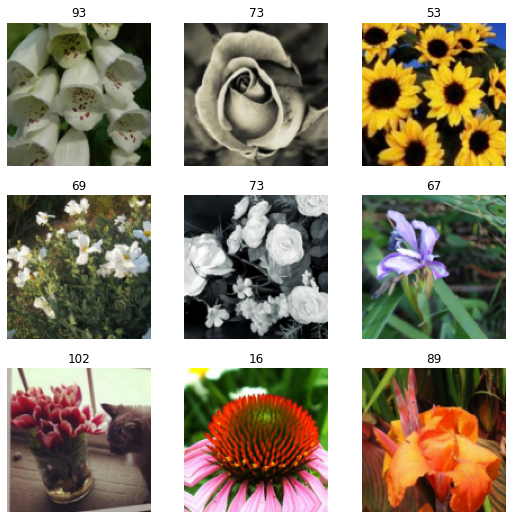

In [9]:
%%time

dls.show_batch()

In [10]:
%%time
model = xresnet34()

learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

CPU times: user 369 ms, sys: 3.81 ms, total: 373 ms
Wall time: 370 ms


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CPU times: user 14.9 s, sys: 6.68 s, total: 21.5 s
Wall time: 23.8 s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0012022644514217973)

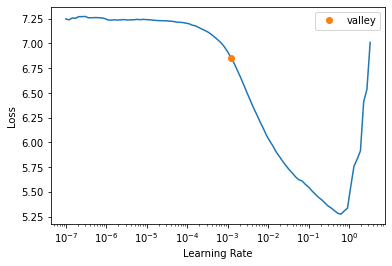

In [11]:
%%time
learn.lr_find()

In [12]:
%%time
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.410060,3.475669,0.188582,00:29
1,2.931155,3.601477,0.164592,00:29
2,2.476413,2.459032,0.355603,00:29
3,2.076491,2.062312,0.442757,00:29
4,1.676050,1.806523,0.518676,00:29
5,1.345170,1.446748,0.611297,00:29
6,1.033074,1.240264,0.669906,00:28
7,0.871266,1.187784,0.682357,00:28


CPU times: user 2min 11s, sys: 1min 5s, total: 3min 17s
Wall time: 3min 54s


In [13]:
%%time
learn.dls = get_dls(224, 64)

learn.fine_tune(freeze_epochs = 3, epochs = 8, base_lr = 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.176832,0.977753,0.730641,00:56
1,1.079885,0.978175,0.715457,00:56
2,0.999212,0.948997,0.745521,00:56


epoch,train_loss,valid_loss,accuracy,time
0,0.837803,0.832039,0.767689,00:56
1,0.816351,0.849150,0.761616,00:56
2,0.797467,0.829582,0.769511,00:55
3,0.715470,0.806919,0.777710,00:56
4,0.665778,0.772264,0.784695,00:56
5,0.621792,0.741043,0.795020,00:55
6,0.579184,0.731694,0.793501,00:56
7,0.541801,0.726063,0.795020,00:56


CPU times: user 6min 24s, sys: 3min 30s, total: 9min 54s
Wall time: 10min 19s


CPU times: user 71.6 ms, sys: 16 ms, total: 87.5 ms
Wall time: 71 ms


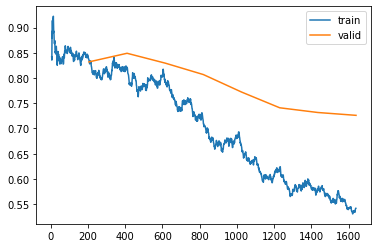

In [14]:
%%time

learn.recorder.plot_loss()

In [15]:
%%time

preds, targs = learn.tta()

CPU times: user 23 s, sys: 8.25 s, total: 31.2 s
Wall time: 35.7 s


In [16]:
%%time

print (accuracy(preds, targs))

TensorBase(0.8026)
CPU times: user 90.3 ms, sys: 934 µs, total: 91.2 ms
Wall time: 16.9 ms


In [17]:
%%time

interp = ClassificationInterpretation.from_learner(learn)

CPU times: user 5.31 s, sys: 4.09 s, total: 9.4 s
Wall time: 8.61 s


CPU times: user 304 ms, sys: 89.6 ms, total: 393 ms
Wall time: 170 ms


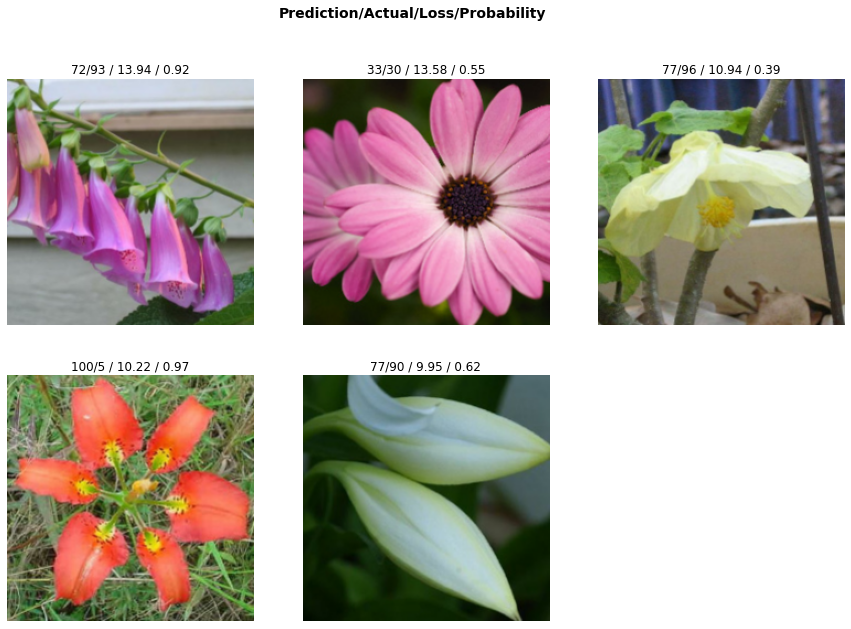

In [18]:
%%time

interp.plot_top_losses(5, nrows = 2, figsize = (15, 10))